# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

- Jordan Dias
- Vaibhav Kumbhar

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Command |
| --- | --- |
| Thumbs up | Increase the volume |
| Thumbs down | Decrease the volume |
| Left swipe | Jump backwards 10 seconds |
| Right swipe | Jump forward 10 seconds |
| Stop | Pause the movie |


## Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 
Two CSV files for the 'train' and a 'val' folder.

Specifically, videos have two types of dimensions - either 360x360 or 120x160



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sys import getsizeof
from PIL import Image
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, TimeDistributed, Dropout, Flatten, BatchNormalization, Activation, Dropout, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
# from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [ ]:
project_path= '/datasets/Project_data/'
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

train_path = project_path + 'train'
val_path = project_path + 'val'

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

In [ ]:
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100



### Function to plot sample images and visualize training result

In [ ]:
# Function to plot sample images
def plot_image(batch_data):
    plt.figure(figsize=(16, 8))
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(batch_data[0,i,:,:,:])
        plt.axis("off")

# Function to visualize training result
def visualize_train_result(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot( acc, label='Training Accuracy')
    plt.plot( val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 120 # image width
img_height = 120 # image height
curr_dt_time = datetime.datetime.now()

In [ ]:
def generator(source_path, folder_list, batch_size):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, total_frames-1, frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resize_img = image.resize((img_height,img_width))
                    nor_img = np.array(resize_img)/255
                    
                    batch_data[folder,idx,:,:,0] = (nor_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (nor_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (nor_img[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resize_img = image.resize((img_height,img_width))
                    nor_img = np.array(resize_img)/255
                    
                    batch_data[folder,idx,:,:,0] = (nor_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (nor_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (nor_img[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Lets visualize few samples.

In [ ]:
sample_gen = generator(train_path, train_doc, 30)

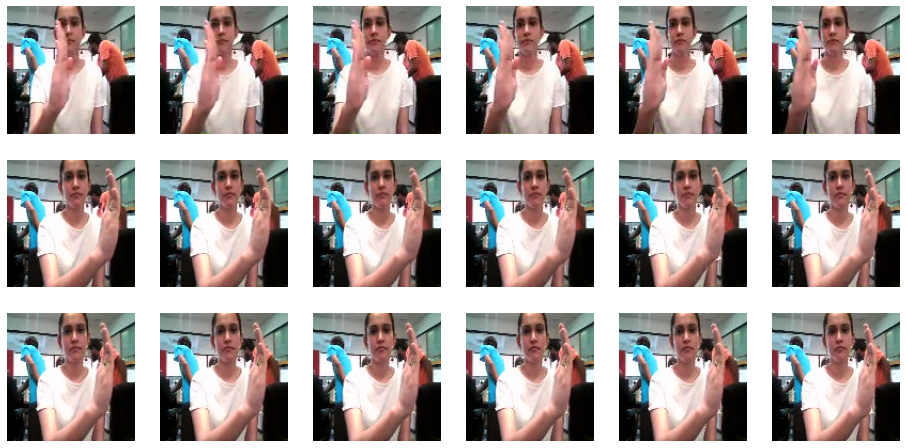

In [ ]:
sample_batch_data, _ = next(sample_gen)
plot_image(sample_batch_data)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

### **Function to train model**

In [ ]:
def train_model(model, batch_size, num_epochs = 10):
    # generators
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

### Base Model

**Function to define sample model**

In [ ]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 160 # image width
img_height = 160 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 51, 20

In [ ]:
def define_model():

    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=sample_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(256, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(512, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))

    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model

In [ ]:
# define and compile model
con_3d_m1 = define_model()

# model summary
print("Total model params:", con_3d_m1.count_params())
con_3d_m1.summary()

Total model params: 27570245
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 32)  2624      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 128)   32896     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 128)   0         
_________________________________________________________________
batch_normalization_1 (Batc

In [ ]:
# train model
# history_m1 = train_model(con_3d_m1, 51, 30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[51,30,160,160,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/batch_normalization/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1928]

Function call stack:
train_function


**We got exhaust resources error for following parameter**
- Image size: (160, 160)
- Frames for a particular video: 30
- Batch size: 51
-------
**ResourceExhaustedError:  OOM when allocating tensor with shape[51,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc**

[[node gradient_tape/sequential_1/max_pooling3d_4/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-24-7c6273a06afb>:87) ]]

Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3012]

Function call stack:
train_function

### For building models we will experiment with
- Image resolution
- Frames for a particular video
- Batch_size


## Model 1
We will start with a simpler model with fewer parameters and lower image size.

In [ ]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 40, 30

In [ ]:
def define_model():
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=sample_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # Flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(5, activation='softmax'))

    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model

In [ ]:
# define and compile model
con_3d_m1 = define_model()

# model summary
print("Total model params:", con_3d_m1.count_params())
print(con_3d_m1.summary())

Total model params: 5097733
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 30, 30, 32)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 30, 30, 64)    55360     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 30, 30, 64)    0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 15, 15, 64)     0         
_________________________________________________________________
conv3d_6 (Conv3D)         

In [ ]:
# train model
history_model_1 = train_model(con_3d_m1, batch_size, num_epochs)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6875 - categorical_accuracy: 0.2051Batch:  3 Index: 40

Epoch 00001: saving model to model_init_2021-09-2517_14_25.356020/model-00001-1.68748-0.20513-1.60619-0.22000.h5
17/17 [==============================] - 65s 4s/step - loss: 1.6875 - categorical_accuracy: 0.2051 - val_loss: 1.6062 - val_categorical_accuracy: 0.2200
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.5929 - categorical_accuracy: 0.2430
Epoch 00002: saving model to model_init_2021-09-2517_14_25.356020/model-00002-1.59290-0.24297-1.58088-0.25000.h5
17/17 [==============================] - 39s 2s/step - loss: 1.5929 - categorical_accuracy: 0.2430 - val_loss: 1.5809 - val_categorical_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.5542 - categorical_accuracy: 0.2670
Epoch 00003: saving model to model_init_2021-09-2517_14_25.356020/model-00003-1.55417-0.26703-1.43882-0.40000.h5
17/17 [==========

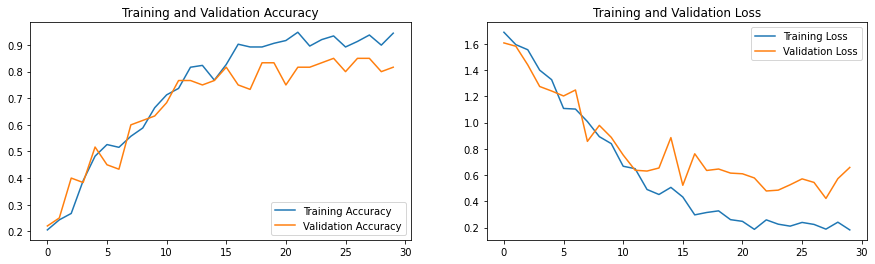

In [ ]:
visualize_train_result(history_model_1)

### Findings
- We got a training accuracy of 94% and validation accuracy of 81%.
- The model gets stable near 25th epoch
- This model is slightly overfitting.

## Model 2
To test the impact of batch size, we will build the same model with low batch size of 25.
We will also reduce the frames to sample and decrease the number of epochs to 25

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 25

In [ ]:
# define and compile model
con_3d_m2 = define_model()

# model summary
print("Total model params:", con_3d_m2.count_params())
print(con_3d_m2.summary())

Total model params: 3492101
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 20, 60, 60, 32)    2624      
_________________________________________________________________
activation_10 (Activation)   (None, 20, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 10, 30, 30, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 30, 30, 64)    55360     
_________________________________________________________________
activation_11 (Activation)   (None, 10, 30, 30, 64)    0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 5, 15, 15, 64)     0         
_________________________________________________________________
conv3d_12 (Conv3D)        

In [ ]:
# train model
history_model_2 = train_model(con_3d_m2, batch_size, num_epochs)

Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.6676 - categorical_accuracy: 0.2157
Epoch 00001: saving model to model_init_2021-09-2517_14_25.356020/model-00001-1.66760-0.21569-1.57926-0.23000.h5
27/27 [==============================] - 43s 2s/step - loss: 1.6676 - categorical_accuracy: 0.2157 - val_loss: 1.5793 - val_categorical_accuracy: 0.2300
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.6006 - categorical_accuracy: 0.2450
Epoch 00002: saving model to model_init_2021-09-2517_14_25.356020/model-00002-1.60061-0.24501-1.45315-0.27000.h5
27/27 [==============================] - 26s 964ms/step - loss: 1.6006 - categorical_accuracy: 0.2450 - val_loss: 1.4532 - val_categorical_accuracy: 0.2700
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 1.4375 - categorical_accuracy: 0.3504
Epoch 00003: saving model to model_init_2021-09-2517_14_25.356020/model-00003-1.43745-0.35043-1.51367-0.26000.h5
27/27 [===========================

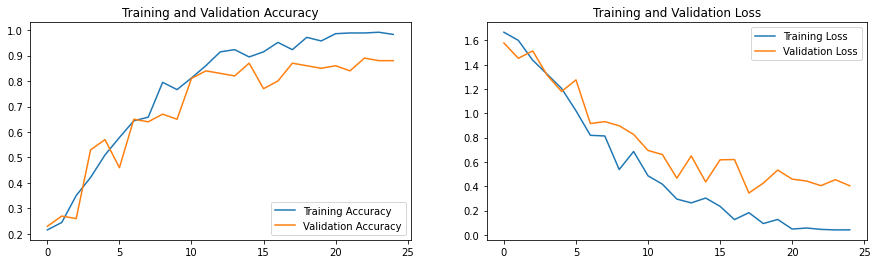

In [ ]:
visualize_train_result(history_model_2)

### Findings

- We got a training accuracy of 98% and validation accuracy of 88%, which is higher than that of model 1 (81%).
- The model starts getting stable after 20th epoch
- This model performance was better after reducing the number of epochs and batch size.
- The model is still slightly overfitting

## Model 3
We will try to further reduce number of epochs to 20 and try adding dropouts in the previous model.

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def define_model_2():
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=sample_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # Flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(5, activation='softmax'))

    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model

In [ ]:
# define and compile model
con_3d_m3 = define_model_2()

# model summary
print("Total model params:", con_3d_m3.count_params())
print(con_3d_m3.summary())

Total model params: 3492101
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 60, 60, 32)    2624      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 30, 30, 32)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 30, 30, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 30, 30, 64)    55360     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 30, 30, 64)    0         
_________________________________________________________________
max_pooling3d_14 (MaxPooli

In [ ]:
# train model
history_model_3 = train_model(con_3d_m3, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6676 - categorical_accuracy: 0.1735
Epoch 00001: saving model to model_init_2021-09-2517_14_25.356020/model-00001-1.66760-0.17345-1.60016-0.29000.h5
27/27 [==============================] - 44s 2s/step - loss: 1.6676 - categorical_accuracy: 0.1735 - val_loss: 1.6002 - val_categorical_accuracy: 0.2900
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6059 - categorical_accuracy: 0.2308
Epoch 00002: saving model to model_init_2021-09-2517_14_25.356020/model-00002-1.60591-0.23077-1.60983-0.14000.h5
27/27 [==============================] - 26s 974ms/step - loss: 1.6059 - categorical_accuracy: 0.2308 - val_loss: 1.6098 - val_categorical_accuracy: 0.1400
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2479
Epoch 00003: saving model to model_init_2021-09-2517_14_25.356020/model-00003-1.59648-0.24786-1.50967-0.36000.h5
27/27 [===========================

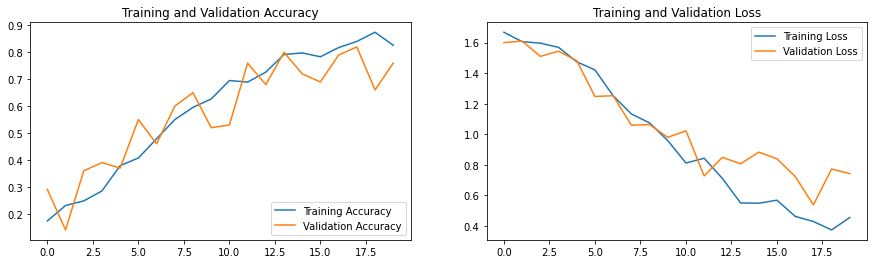

In [ ]:
visualize_train_result(history_model_3)

### Findings
- We got a training accuracy of 82% and validation accuracy of 76%.
- Adding dropouts to the model reduced overfitting.
- Adding dropouts also made the model unstable.

## Model 4
Let's build another model, based on Model 2 but without the dropouts. We will try to increase the image size to (100 X 100) to see the effect on performance.

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def define_model_3():
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=sample_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))

    # Flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(5, activation='softmax'))

    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model

In [ ]:
# define and compile model
con_3d_m4 = define_model_3()

# model summary
print("Total model params:", con_3d_m4.count_params())
print(con_3d_m4.summary())

Total model params: 9718021
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 20, 100, 100, 32)  2624      
_________________________________________________________________
activation_22 (Activation)   (None, 20, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 10, 50, 50, 32)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 10, 50, 50, 64)    55360     
_________________________________________________________________
activation_23 (Activation)   (None, 10, 50, 50, 64)    0         
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 5, 25, 25, 64)     0         
_________________________________________________________________
conv3d_24 (Conv3D)        

In [ ]:
# train model
history_model_4 = train_model(con_3d_m4, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.8541 - categorical_accuracy: 0.2157
Epoch 00001: saving model to model_init_2021-09-2517_14_25.356020/model-00001-1.85408-0.21569-1.60172-0.18000.h5
27/27 [==============================] - 49s 2s/step - loss: 1.8541 - categorical_accuracy: 0.2157 - val_loss: 1.6017 - val_categorical_accuracy: 0.1800
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5552 - categorical_accuracy: 0.2821
Epoch 00002: saving model to model_init_2021-09-2517_14_25.356020/model-00002-1.55517-0.28205-1.38587-0.31000.h5
27/27 [==============================] - 30s 1s/step - loss: 1.5552 - categorical_accuracy: 0.2821 - val_loss: 1.3859 - val_categorical_accuracy: 0.3100
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.3812 - categorical_accuracy: 0.3875
Epoch 00003: saving model to model_init_2021-09-2517_14_25.356020/model-00003-1.38117-0.38746-1.21369-0.43000.h5
27/27 [==============================

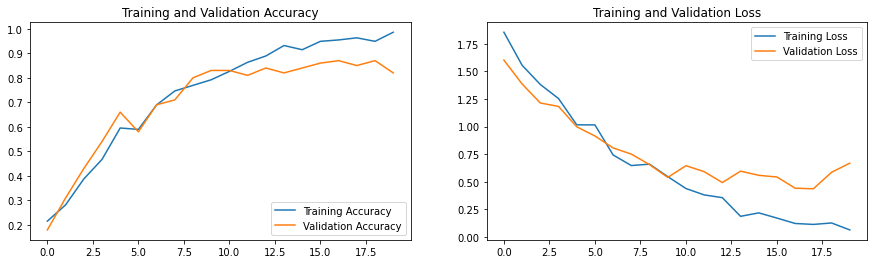

In [ ]:
visualize_train_result(history_model_4)

### Findings
- Although this model's training accuracy is 98% and validation accuracy of 82%, the model was stable until 19th epoch.
- This model has 9.7 million paramters; which means increasing batch size makes the model heavy.


## Model 5
The previous model was heavy. We will run the same model 4 with image size set to (80 X 80) and number of epochs set to 18.

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 80 # image width
img_height = 80 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 18

In [ ]:
# define and compile model
con_3d_m5 = define_model_3()

# model summary
print("Total model params:", con_3d_m5.count_params())
print(con_3d_m5.summary())

Total model params: 6834437
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 80, 80, 32)    2624      
_________________________________________________________________
activation (Activation)      (None, 20, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 40, 40, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 40, 40, 64)    55360     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 40, 40, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 20, 20, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)           

In [ ]:
# train model
history_model_5 = train_model(con_3d_m5, batch_size, num_epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/18
27/27 [==============================] - ETA: 0s - loss: 1.6385 - categorical_accuracy: 0.2051
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.63851-0.20513-1.51262-0.31000.h5
27/27 [==============================] - 45s 2s/step - loss: 1.6385 - categorical_accuracy: 0.2051 - val_loss: 1.5126 - val_categorical_accuracy: 0.3100
Epoch 2/18
27/27 [==============================] - ETA: 0s - loss: 1.4623 - categorical_accuracy: 0.3675
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.46227-0.36752-1.18831-0.46000.h5
27/27 [==============================] - 28s 1s/step - loss: 1.4623 - categorical_accuracy: 0.3675 - val_loss: 1.1883 - val_categorical_accuracy: 0.4600
Epoch 3/18
27/27 [==============================] - ETA: 0s - loss: 1.4330 - categorical_accuracy: 0.3789
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00

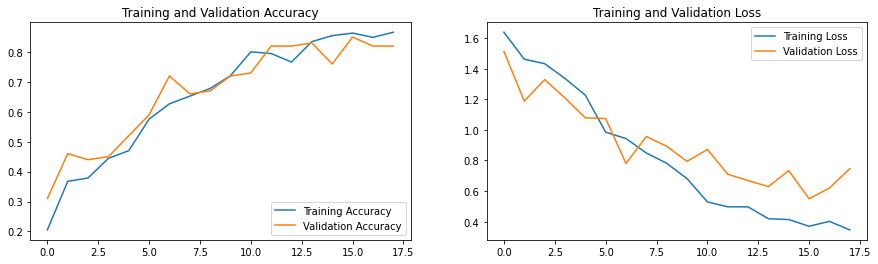

In [ ]:
visualize_train_result(history_model_5)

### Findings
- We got a training accuracy of 86% and validation accuracy of 82%. 
- We were able to control the overfitting. 
- With more epochs, we might have gotten higher accuracy.

## Checking another model architecture

## Model 6

We will add another hidden layer and train the new model

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 80 # image width
img_height = 80 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def model_b1():
    model_b = Sequential()
    model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model_b.add(Dropout(0.25))

    model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model_b.add(Dropout(0.25))

    model_b.add(Flatten())
    model_b.add(Dense(256, activation='relu'))
    model_b.add(Dropout(0.5))
    model_b.add(Dense(5, activation='softmax'))
    
    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model_b.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model_b

In [ ]:
# define and compile model
con_3d_b1 = model_b1()

# model summary
print("Total model params:", con_3d_b1.count_params())
print(con_3d_b1.summary())

Total model params: 4179173
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 20, 80, 80, 32)    2624      
_________________________________________________________________
activation_33 (Activation)   (None, 20, 80, 80, 32)    0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 20, 80, 80, 32)    27680     
_________________________________________________________________
activation_34 (Activation)   (None, 20, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 7, 27, 27, 32)     0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 27, 27, 32)     0         
_________________________________________________________________
conv3d_35 (Conv3D)       

In [ ]:
history_model_b1 = train_model(con_3d_b1, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6532 - categorical_accuracy: 0.1916
Epoch 00001: saving model to model_init_2021-09-2517_14_25.356020/model-00001-1.65319-0.19155-1.59842-0.23000.h5
27/27 [==============================] - 46s 2s/step - loss: 1.6532 - categorical_accuracy: 0.1916 - val_loss: 1.5984 - val_categorical_accuracy: 0.2300
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.2137
Epoch 00002: saving model to model_init_2021-09-2517_14_25.356020/model-00002-1.60986-0.21368-1.61014-0.19000.h5
27/27 [==============================] - 29s 1s/step - loss: 1.6099 - categorical_accuracy: 0.2137 - val_loss: 1.6101 - val_categorical_accuracy: 0.1900
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2108
Epoch 00003: saving model to model_init_2021-09-2517_14_25.356020/model-00003-1.60918-0.21083-1.60159-0.22000.h5

Epoch 00003: ReduceLROnPlateau reduc

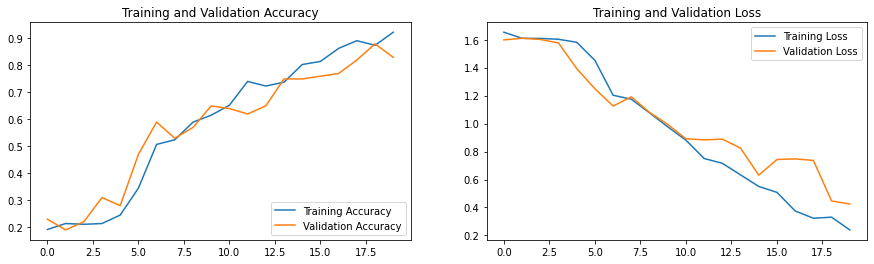

In [ ]:
visualize_train_result(history_model_b1)

### Findings 
- We got a training accuracy of 92% and validation accuracy of 83%. 
- The training and validation accuracy is increasing in a linear fashion. 
- The model is overfitting.


## Model 7
The previous model is overfitting. We will try to increase number of frames and reduce the image size to (60 X 60) 

In [ ]:
frames_to_sample = 24 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
# define and compile model
con_3d_b2 = model_b1()

# model summary
print("Total model params:", con_3d_b2.count_params())
print(con_3d_b2.summary())

Total model params: 2606309
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_47 (Conv3D)           (None, 24, 60, 60, 32)    2624      
_________________________________________________________________
activation_47 (Activation)   (None, 24, 60, 60, 32)    0         
_________________________________________________________________
conv3d_48 (Conv3D)           (None, 24, 60, 60, 32)    27680     
_________________________________________________________________
activation_48 (Activation)   (None, 24, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 20, 20, 32)     0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 20, 20, 32)     0         
_________________________________________________________________
conv3d_49 (Conv3D)       

In [ ]:
history_model_b2 = train_model(con_3d_b2, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6702 - categorical_accuracy: 0.1900
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.67022-0.19005-1.60272-0.23000.h5
27/27 [==============================] - 51s 2s/step - loss: 1.6702 - categorical_accuracy: 0.1900 - val_loss: 1.6027 - val_categorical_accuracy: 0.2300
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5903 - categorical_accuracy: 0.2678
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.59032-0.26781-1.44346-0.22000.h5
27/27 [==============================] - 32s 1s/step - loss: 1.5903 - categorical_accuracy: 0.2678 - val_loss: 1.4435 - val_categorical_accuracy: 0.2200
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.4392 - categorical_accuracy: 0.2849
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-1.43918-0.28490-1.15194-0.49000.h5
27/27 [==============================

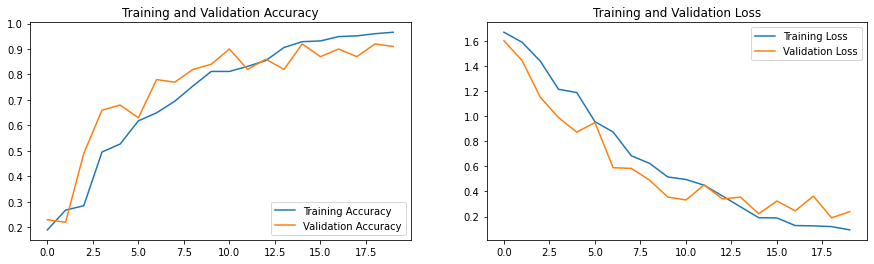

In [ ]:
visualize_train_result(history_model_b2)

### Findings 
- After reducing the image size and increasing the number of frames, we got a training accuracy of 96% and validation accuracy of 91%
- The model is no longer overfitting.
- There was a steady growth in training and validation accuracy and steady reduction in training and validation loss.
- The small model size and good accuracy makes it the best model so far.

## Model 8
In order to check the impact of kernal size, we wil change the  kernal size to (2 X 2 X 2) of previous model and image size to (80 X 80), while keeping other parameters same as before.

In [ ]:
frames_to_sample = 24 # number of frames to use
total_frames = 30 # number of frames
img_width = 80 # image width
img_height = 80 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def model_b2():
    model_b = Sequential()
    model_b.add(Conv3D(32, kernel_size=(2, 2, 2), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model_b.add(Dropout(0.25))

    model_b.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model_b.add(Activation('relu'))
    model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model_b.add(Dropout(0.25))

    model_b.add(Flatten())
    model_b.add(Dense(256, activation='relu'))
    model_b.add(Dropout(0.5))
    model_b.add(Dense(5, activation='softmax'))
    
    # compile model
    optimiser = optimizers.Adam()
    loss = 'categorical_crossentropy'
    model_b.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

    return model_b

In [ ]:
# define and compile model
con_3d_b2 = model_b2()

# model summary
print("Total model params:", con_3d_b2.count_params())
print(con_3d_b2.summary())

Total model params: 4041157
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_75 (Conv3D)           (None, 24, 80, 80, 32)    800       
_________________________________________________________________
activation_75 (Activation)   (None, 24, 80, 80, 32)    0         
_________________________________________________________________
conv3d_76 (Conv3D)           (None, 24, 80, 80, 32)    8224      
_________________________________________________________________
activation_76 (Activation)   (None, 24, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 8, 27, 27, 32)     0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 8, 27, 27, 32)     0         
_________________________________________________________________
conv3d_77 (Conv3D)       

In [ ]:
# train model
history_model_8 = train_model(con_3d_b2, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.7868 - categorical_accuracy: 0.2097
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.78676-0.20965-1.59296-0.23000.h5
27/27 [==============================] - 54s 2s/step - loss: 1.7868 - categorical_accuracy: 0.2097 - val_loss: 1.5930 - val_categorical_accuracy: 0.2300
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5931 - categorical_accuracy: 0.2393
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.59314-0.23932-1.52756-0.26000.h5
27/27 [==============================] - 34s 1s/step - loss: 1.5931 - categorical_accuracy: 0.2393 - val_loss: 1.5276 - val_categorical_accuracy: 0.2600
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.4590 - categorical_accuracy: 0.3362
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-1.45903-0.33618-1.34112-0.44000.h5
27/27 [==============================

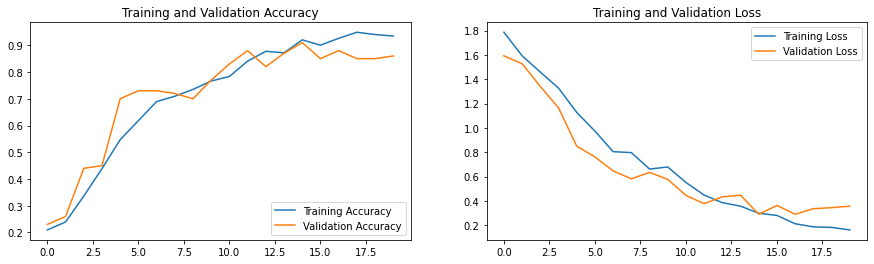

In [ ]:
visualize_train_result(history_model_8)

### Findings
- Reducing kernal size of each layer didn't account for any major changes in the model
- We got training accuracy of 93% and validation accuracy of 86%
- previous model gave similar performance with lower image size.

## Model 9 - Con2d with GRU
Batch Size: 25, Image resolution: (100,100), Frames for a video: 20

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def model_gru():
    model_gru = Sequential()

    model_gru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(frames_to_sample, img_height,img_width, 3)))
    model_gru.add(TimeDistributed(MaxPooling2D((3, 3))))

    model_gru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_gru.add(TimeDistributed(MaxPooling2D((3, 3))))

    model_gru.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_gru.add(TimeDistributed(MaxPooling2D((3, 3))))
    model_gru.add(Dropout(0.25))

    model_gru.add(TimeDistributed(Flatten()))

    model_gru.add(GRU(128))
    model_gru.add(Dropout(0.25))

    model_gru.add(Dense(128,activation='relu'))
    model_gru.add(Dropout(0.5))

    model_gru.add(Dense(5, activation='softmax'))
    
    return model_gru

In [ ]:
# compile model
model_gru_1 = model_gru()
optimiser = optimizers.Adam()
loss = 'categorical_crossentropy'
model_gru_1.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

In [ ]:
print("Total model params:", model_gru_1.count_params())
print(model_gru_1.summary())

Total model params: 602693
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 20, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 33, 33, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 33, 33, 64)    18496     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 11, 11, 64)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 11, 11, 128)   73856     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 3, 3, 128)     0         
_________________________________________________________________
dropout_64 (Dropout)      

In [ ]:
# train model
history_gru_m1 = train_model(model_gru_1, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6236 - categorical_accuracy: 0.2021
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.62359-0.20211-1.59842-0.23000.h5
27/27 [==============================] - 49s 2s/step - loss: 1.6236 - categorical_accuracy: 0.2021 - val_loss: 1.5984 - val_categorical_accuracy: 0.2300
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6010 - categorical_accuracy: 0.2165
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.60104-0.21652-1.59138-0.17000.h5
27/27 [==============================] - 30s 1s/step - loss: 1.6010 - categorical_accuracy: 0.2165 - val_loss: 1.5914 - val_categorical_accuracy: 0.1700
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5767 - categorical_accuracy: 0.2422
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-1.57672-0.24217-1.50190-0.40000.h5
27/27 [==============================

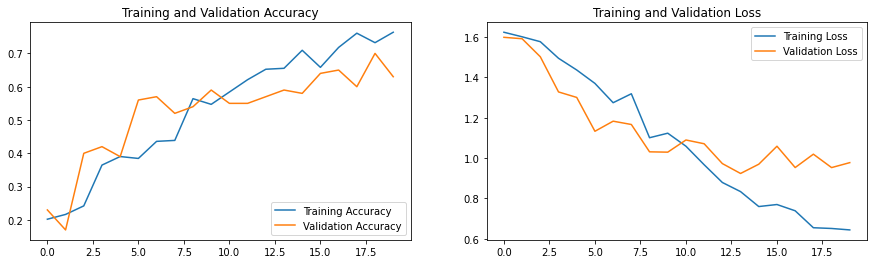

In [ ]:
visualize_train_result(history_gru_m1)

### Findings
- We got a training accuracy of 76% and validation accuracy of 63%.
- The improvement in validation accuracy reduced after 7th epoch.

## Con2D with LSTM

## Model 10
We will try to build a LSTM model with the following paramters.
Batch Size: 25, Image resolution: (120,120), Frames for a video: 20

In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 120 # image width
img_height = 120 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 20

In [ ]:
def model_lstm():
    model_lstm = Sequential()

    model_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(frames_to_sample, img_height,img_width, 3)))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Flatten()))

    model_lstm.add(LSTM(128))
    model_lstm.add(Dropout(0.25))

    model_lstm.add(Dense(128,activation='relu'))
    model_lstm.add(Dropout(0.5))

    model_lstm.add(Dense(5, activation='softmax'))
    
    return model_lstm

In [ ]:
# compile model
model_lstm = model_lstm()
optimiser = optimizers.Adam(lr=0.0002)
loss = 'categorical_crossentropy'
model_lstm.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

In [ ]:
# model summary
print("Total model params:", model_lstm.count_params())
print(model_lstm.summary())

Total model params: 3535301
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_102 (TimeDi (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_103 (TimeDi (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_104 (TimeDi (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_105 (TimeDi (None, 20, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_106 (TimeDi (None, 20, 30, 30, 128)   73856     
_________________________________________________________________
time_distributed_107 (TimeDi (None, 20, 15, 15, 128)   0         
_________________________________________________________________
time_distributed_108 (Tim

In [ ]:
# train model
history_lstm_m1 = train_model(model_lstm, batch_size, num_epochs)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6163 - categorical_accuracy: 0.2006
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.61628-0.20060-1.59312-0.23000.h5
27/27 [==============================] - 52s 2s/step - loss: 1.6163 - categorical_accuracy: 0.2006 - val_loss: 1.5931 - val_categorical_accuracy: 0.2300
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.2279
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.60697-0.22792-1.58991-0.29000.h5
27/27 [==============================] - 31s 1s/step - loss: 1.6070 - categorical_accuracy: 0.2279 - val_loss: 1.5899 - val_categorical_accuracy: 0.2900
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5724 - categorical_accuracy: 0.2308
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-1.57241-0.23077-1.50582-0.29000.h5
27/27 [==============================

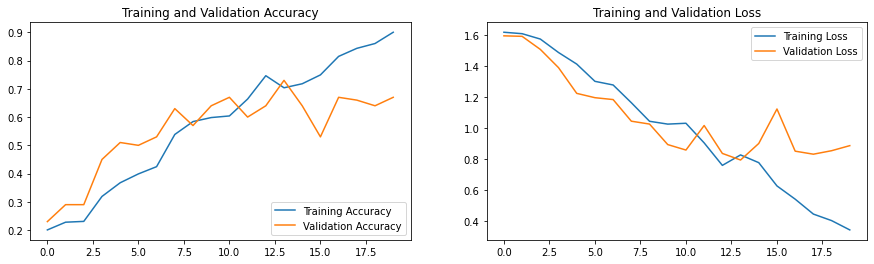

In [ ]:
visualize_train_result(history_lstm_m1)

### Findings
- We got a training accuracy of 88% and validation accuracy of 71%. 
- This model is overfitting.
- We will try the next model by decreasing image size and and increasing the batch size

## Model 11
We will try to build another model with same layers but only add more nuerons in the LSTM model.
Batch Size: 25, Image resolution: (80,80), Frames for a video: 24

In [ ]:
frames_to_sample = 24 # number of frames to use
total_frames = 30 # number of frames
img_width = 80 # image width
img_height = 80 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 25, 25

In [ ]:
def model_lstm_2():
    model_lstm = Sequential()

    model_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(frames_to_sample, img_height,img_width, 3)))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    model_lstm.add(Dropout(0.25))

    model_lstm.add(TimeDistributed(Flatten()))

    model_lstm.add(LSTM(256))
    model_lstm.add(Dropout(0.25))

    model_lstm.add(Dense(128,activation='relu'))
    model_lstm.add(Dropout(0.5))

    model_lstm.add(Dense(5, activation='softmax'))
    
    return model_lstm

In [ ]:
# compile model
model_lstm_2 = model_lstm_2()
optimiser = optimizers.Adam(lr=0.0002)
loss = 'categorical_crossentropy'
model_lstm_2.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

In [ ]:
# model summary
print("Total model params:", model_lstm_2.count_params())
print(model_lstm_2.summary())

Total model params: 3703685
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_111 (TimeDi (None, 24, 80, 80, 32)    896       
_________________________________________________________________
time_distributed_112 (TimeDi (None, 24, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_113 (TimeDi (None, 24, 40, 40, 64)    18496     
_________________________________________________________________
time_distributed_114 (TimeDi (None, 24, 20, 20, 64)    0         
_________________________________________________________________
time_distributed_115 (TimeDi (None, 24, 20, 20, 64)    36928     
_________________________________________________________________
time_distributed_116 (TimeDi (None, 24, 10, 10, 64)    0         
_________________________________________________________________
time_distributed_117 (Tim

In [ ]:
# train model
history_lstm_m2 = train_model(model_lstm_2, batch_size, num_epochs)

Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.6157 - categorical_accuracy: 0.2142
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.61572-0.21418-1.59839-0.22000.h5
27/27 [==============================] - 55s 2s/step - loss: 1.6157 - categorical_accuracy: 0.2142 - val_loss: 1.5984 - val_categorical_accuracy: 0.2200
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2450
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.60557-0.24501-1.56619-0.29000.h5
27/27 [==============================] - 34s 1s/step - loss: 1.6056 - categorical_accuracy: 0.2450 - val_loss: 1.5662 - val_categorical_accuracy: 0.2900
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 1.6042 - categorical_accuracy: 0.1852
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-1.60416-0.18519-1.58384-0.25000.h5
27/27 [==============================

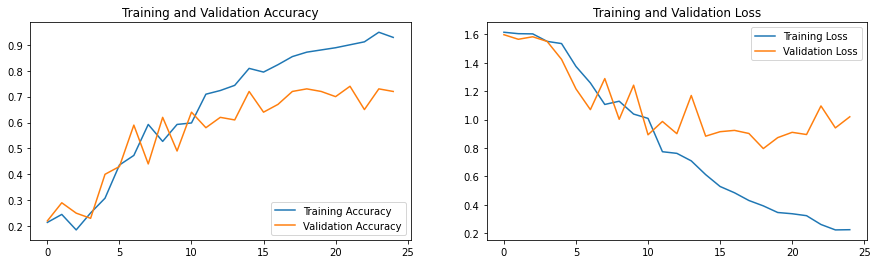

In [ ]:
visualize_train_result(history_lstm_m2)

### Findings

- We got a training accuracy of 92% and validation accuracy of 82%.
- Adding more nuerons and reducing batch size didn't reduce overfitting.
- Increasing number of epochs increased accuracy from previous model since it got more time to train.

## Transfer Learning

### Model 12

We will build a model using pre-trained weights from Mobile Net. Since mobile net is a comparitively light model, we can utilize it for smaller devices.

In [ ]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 3s 0us/step


In [ ]:
frames_to_sample = 20 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height
channels = 3 # number of channels
sample_shape = (frames_to_sample, img_height, img_width, channels)
batch_size, num_epochs = 10, 20

In [ ]:
def cnn3d_transfer():
    model = Sequential()
    
    model.add(TimeDistributed(mobilenet_transfer,input_shape=sample_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
# define and compile model
conv3d_transfer_m1 = cnn3d_transfer()

# model summary
print("Total model params:", conv3d_transfer_m1.count_params())

conv3d_transfer_m1.summary()

Total model params: 3693253
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_120 (TimeDi (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_121 (TimeDi (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_122 (TimeDi (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_123 (TimeDi (None, 20, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_90 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)         

In [ ]:
# train model
history_TL_m1 = train_model(conv3d_transfer_m1, batch_size, num_epochs)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4658 - categorical_accuracy: 0.3876
Epoch 00001: saving model to model_init_2021-09-2609_26_04.755457/model-00001-1.46583-0.38763-0.93998-0.75000.h5
67/67 [==============================] - 51s 757ms/step - loss: 1.4658 - categorical_accuracy: 0.3876 - val_loss: 0.9400 - val_categorical_accuracy: 0.7500
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0704 - categorical_accuracy: 0.5771
Epoch 00002: saving model to model_init_2021-09-2609_26_04.755457/model-00002-1.07042-0.57711-0.98342-0.65000.h5
67/67 [==============================] - 22s 334ms/step - loss: 1.0704 - categorical_accuracy: 0.5771 - val_loss: 0.9834 - val_categorical_accuracy: 0.6500
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9366 - categorical_accuracy: 0.6816
Epoch 00003: saving model to model_init_2021-09-2609_26_04.755457/model-00003-0.93662-0.68159-0.61686-0.79000.h5
67/67 [========================

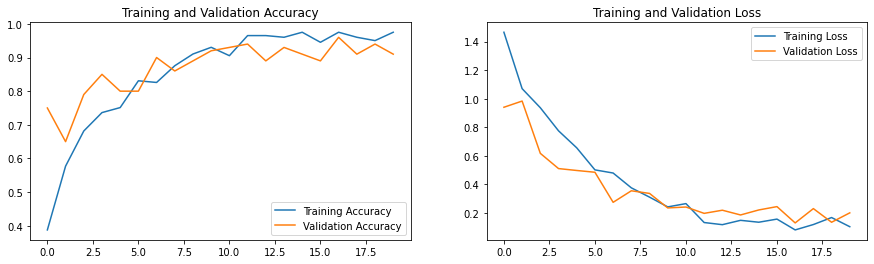

In [ ]:
visualize_train_result(history_TL_m1)

### Findings
- We are getting a very good accuracy of train 97% and validation 91%.
- This model is stable and has a very good validation accuracy even with smaller size
- Model gained good accuracy stability just after 10th epoch